In [18]:
#Importing the packages
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import nltk
import re,string
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword=set(stopwords.words('english'))
stemmer = nltk.SnowballStemmer("english")

df = pd.read_csv("C:\\Users\\Admin\\Downloads\\twitter_data.csv")

print(df.shape)

df.head(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(24783, 7)


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [19]:
nlp = spacy.load("en_core_web_lg", disable=["tagger"])

In [20]:
df["labels"] = df['class'].map({0: "Hate Speech", 1: "Offensive Speech", 2: "No Hate and Offensive Speech"})
df = df[["tweet", "labels"]]

In [21]:
 def preprocess(text):
        test_list = text.split()
        text = ""
        for word in test_list:
            if word.endswith("ing"):
                word=word[:-3]
            text+=word
            text+=" "
        doc = nlp(text)
        filtered_tokens = []
        
        for token in doc:
            if token.is_stop or token.is_punct:
                continue
            filtered_tokens.append(token.lemma_)
            
        return " ".join(filtered_tokens)

In [22]:
df["tweet_new"] = df.tweet.apply(preprocess)

C:\Users\Admin\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [23]:
df.head()

,tweet,labels,tweet_new
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate and Offensive Speech,rt @mayasolovely woman complain clean house am...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Speech,rt @mleew17 boy dats cold tyga dwn bad cuffin ...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Speech,rt @urkindofbrand dawg rt @80sbaby4life fuck b...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Speech,rt @c_g_anderson @viva_based look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Speech,rt @shenikaroberts shit hear true faker bitch ...


In [24]:
def clean(text):
    text = str (text). lower()
    text = re. sub('[.?]', '', text)
    text = re. sub('https?://\S+|www.\S+', '', text)
    text = re. sub('<.?>+', '', text)
    text = re. sub('[%s]' % re. escape(string. punctuation), '', text)
    text = re. sub('\n', '', text)
    text = re. sub('\w\d\w', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ". join(text)
    text = [stemmer. stem(word) for word in text. split(' ')]
    text=" ". join(text)
    return text

In [25]:
df["tweet_new"] = df.tweet_new.apply(clean)

In [26]:
# Load pre-trained GloVe word vectors
glove_vectors = {}  # Create a dictionary to store GloVe word vectors

# Load GloVe word vectors from the downloaded file
glove_file = "C:\\Users\\Admin\\glove.twitter.27B.200d.txt" 
with open(glove_file, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype="float32")
        glove_vectors[word] = vector

In [10]:
# Define a function to convert a sentence to an average GloVe word vector using spaCy and GloVe
def sentence_to_vector(sentence, model, word_vectors):
    doc = model(sentence)
    vector = np.zeros(word_vectors["the"].shape)  # Initialize with a vector of zeros
    num_words = 0
    for word in doc:
        if word.text in word_vectors:
            vector += word_vectors[word.text]
            num_words += 1
    if num_words > 0:
        vector /= num_words
    return vector

In [27]:
x = np. array(df["tweet_new"])
y = np. array(df["labels"])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [28]:
# Convert training data to average GloVe word vectors
X_train_glove = [sentence_to_vector(sentence, nlp, glove_vectors) for sentence in X_train]

C:\Users\Admin\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [29]:
from sklearn.preprocessing import LabelEncoder
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Split data into training and testing
X_train_glv, X_test_glv, y_train_enc, y_test_enc = train_test_split(X_train_glove, y_train_encoded, test_size=0.2, random_state=42)

In [30]:
from sklearn.svm import SVC

# Define and train an SVM classifier
clf = SVC(probability=True)
clf.fit(X_train_glv, y_train_enc)

#Testing the model
y_pred = clf.predict (X_test_glv)
#Accuracy Score of our model
from sklearn.metrics import accuracy_score
print (accuracy_score (y_test_enc,y_pred))

'''# Preprocess and clean the new input
new_string = "string"
new_string = preprocess(new_string)

# Convert the new input to an average GloVe word vector
new_string_vector = sentence_to_vector(new_string, nlp, glove_vectors).reshape(1, -1)

# Predict the label
predicted_label_encoded = clf.predict(new_string_vector)
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

print("Predicted Label:", predicted_label)'''

0.8882866606443842


'# Preprocess and clean the new input\nnew_string = "string"\nnew_string = preprocess(new_string)\n\n# Convert the new input to an average GloVe word vector\nnew_string_vector = sentence_to_vector(new_string, nlp, glove_vectors).reshape(1, -1)\n\n# Predict the label\npredicted_label_encoded = clf.predict(new_string_vector)\npredicted_label = label_encoder.inverse_transform(predicted_label_encoded)\n\nprint("Predicted Label:", predicted_label)'

SVM Accuracy: 0.8882866606443842
SVM F1 Score: 0.8654033854819464
SVM Precision: 0.873221839239011
SVM Recall: 0.8882866606443842
SVM AUC Scores per class: 0.9281156238521003
SVM Confusion Matrix:
[[   8   32  154]
 [   0  461   92]
 [   5   88 2481]]


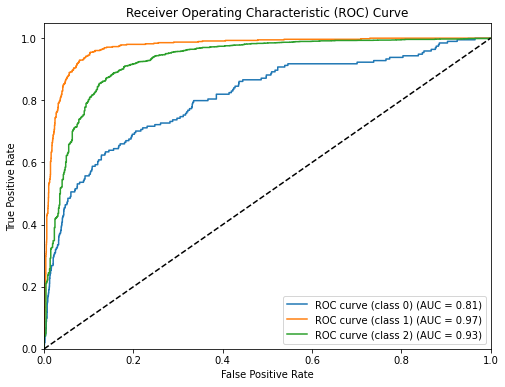

In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
svm_accuracy = accuracy_score(y_test_enc, clf.predict(X_test_glv))
print("SVM Accuracy:", svm_accuracy)

# Calculate F1 score
svm_f1_score = f1_score(y_test_enc, clf.predict(X_test_glv), average='weighted')
print("SVM F1 Score:", svm_f1_score)

# Calculate precision
svm_precision = precision_score(y_test_enc, clf.predict(X_test_glv), average='weighted')
print("SVM Precision:", svm_precision)

# Calculate recall
svm_recall = recall_score(y_test_enc, clf.predict(X_test_glv), average='weighted')
print("SVM Recall:", svm_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels
y_test_binarized = label_binarize(y_test_enc, classes=range(len(label_encoder.classes_)))
# Calculate ROC AUC score for each class separately
y_score = clf.predict_proba(X_test_glv)
svm_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("SVM AUC Scores per class:", svm_auc_scores)

# Calculate confusion matrix
svm_conf_matrix = confusion_matrix(y_test_enc, clf.predict(X_test_glv))
print("SVM Confusion Matrix:")
print(svm_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [32]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression()
model1.fit(X_train_glv,y_train_enc)
y_pred = model1.predict(X_test_glv)

#Accuracy Score of our model
from sklearn.metrics import accuracy_score
print (accuracy_score (y_test_enc,y_pred))

'''# Preprocess and clean the new input
new_string = "string"
new_string = preprocess(new_string)

# Convert the new input to an average GloVe word vector
new_string_vector = sentence_to_vector(new_string, nlp, glove_vectors).reshape(1, -1)

# Predict the label
predicted_label_encoded = model1.predict(new_string_vector)
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

print("Predicted Label:", predicted_label)'''

0.8846732911773563


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'# Preprocess and clean the new input\nnew_string = "string"\nnew_string = preprocess(new_string)\n\n# Convert the new input to an average GloVe word vector\nnew_string_vector = sentence_to_vector(new_string, nlp, glove_vectors).reshape(1, -1)\n\n# Predict the label\npredicted_label_encoded = model1.predict(new_string_vector)\npredicted_label = label_encoder.inverse_transform(predicted_label_encoded)\n\nprint("Predicted Label:", predicted_label)'

lr Accuracy: 0.8846732911773563
lr F1 Score: 0.8711134797384048
lr Precision: 0.8682227880564081
lr Recall: 0.8846732911773563
lr AUC Scores per class: 0.9281156238521003
lr Confusion Matrix:
[[  30   28  136]
 [   2  453   98]
 [  30   89 2455]]


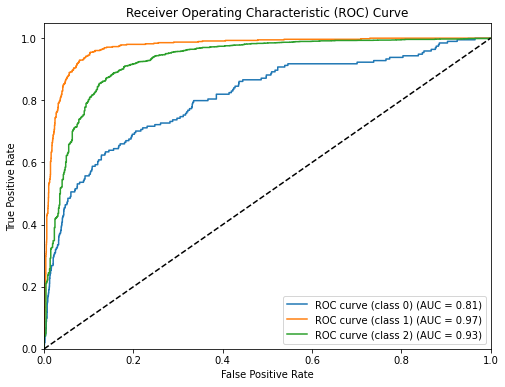

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
lr_accuracy = accuracy_score(y_test_enc, y_pred)
print("lr Accuracy:", lr_accuracy)

# Calculate F1 score
lr_f1_score = f1_score(y_test_enc, y_pred, average='weighted')
print("lr F1 Score:", lr_f1_score)

# Calculate precision
lr_precision = precision_score(y_test_enc, y_pred, average='weighted')
print("lr Precision:", lr_precision)

# Calculate recall
lr_recall = recall_score(y_test_enc, y_pred, average='weighted')
print("lr Recall:", lr_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels
y_test_binarized = label_binarize(y_test_enc, classes=range(len(label_encoder.classes_)))
# Calculate ROC AUC score for each class separately
y_score = clf.predict_proba(X_test_glv)
lr_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("lr AUC Scores per class:", lr_auc_scores)

# Calculate confusion matrix
lr_conf_matrix = confusion_matrix(y_test_enc, y_pred)
print("lr Confusion Matrix:")
print(lr_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Define and train an SVM classifier
clf = RandomForestClassifier()
clf.fit(X_train_glv, y_train_enc)

#Testing the model
y_pred = clf.predict (X_test_glv)
#Accuracy Score of our model
from sklearn.metrics import accuracy_score
print (accuracy_score (y_test_enc,y_pred))

'''# Preprocess and clean the new input
new_string = "string"
new_string = preprocess(new_string)

# Convert the new input to an average GloVe word vector
new_string_vector = sentence_to_vector(new_string, nlp, glove_vectors).reshape(1, -1)

# Predict the label
predicted_label_encoded = clf.predict(new_string_vector)
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

print("Predicted Label:", predicted_label)'''

0.8717253839205059


'# Preprocess and clean the new input\nnew_string = "string"\nnew_string = preprocess(new_string)\n\n# Convert the new input to an average GloVe word vector\nnew_string_vector = sentence_to_vector(new_string, nlp, glove_vectors).reshape(1, -1)\n\n# Predict the label\npredicted_label_encoded = clf.predict(new_string_vector)\npredicted_label = label_encoder.inverse_transform(predicted_label_encoded)\n\nprint("Predicted Label:", predicted_label)'

Random Forest Accuracy: 0.8717253839205059
Random Forest F1 Score: 0.847471135893791
Random Forest Precision: 0.8483260724932096
Random Forest Recall: 0.8717253839205059
Random Forest AUC Scores per class: 0.8975614077598831
Random Forest Confusion Matrix:
[[   9   27  158]
 [   0  385  168]
 [  10   63 2501]]


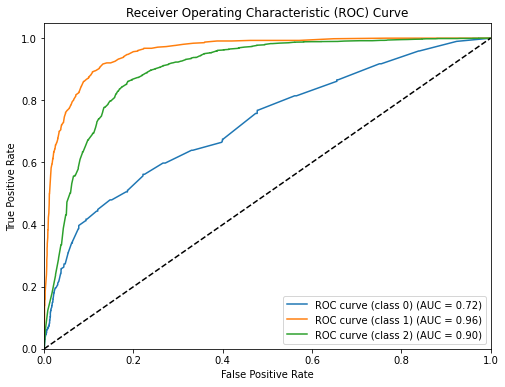

In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
rf_accuracy = accuracy_score(y_test_enc, clf.predict(X_test_glv))
print("Random Forest Accuracy:", rf_accuracy)

# Calculate F1 score
rf_f1_score = f1_score(y_test_enc, clf.predict(X_test_glv), average='weighted')
print("Random Forest F1 Score:", rf_f1_score)

# Calculate precision
rf_precision = precision_score(y_test_enc, clf.predict(X_test_glv), average='weighted')
print("Random Forest Precision:", rf_precision)

# Calculate recall
rf_recall = recall_score(y_test_enc, clf.predict(X_test_glv), average='weighted')
print("Random Forest Recall:", rf_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels
y_test_binarized = label_binarize(y_test_enc, classes=range(len(label_encoder.classes_)))

# Calculate ROC AUC score for each class separately
y_score = clf.predict_proba(X_test_glv)
rf_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("Random Forest AUC Scores per class:", rf_auc_scores)

# Calculate confusion matrix
rf_conf_matrix = confusion_matrix(y_test_enc, clf.predict(X_test_glv))
print("Random Forest Confusion Matrix:")
print(rf_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [36]:
from sklearn.ensemble import VotingClassifier

# Initialize individual models
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
svm_model = SVC(kernel='linear', probability=True)  # Enable probability estimation for SVM

# Define the ensemble of models
ensemble_model = VotingClassifier(estimators=[
    ('decision_tree', dt_model),
    ('random_forest', rf_model),
    ('svm', svm_model)
], voting='soft')  # Use soft voting for probability averaging

# Training the ensemble model
ensemble_model.fit(X_train_glv, y_train_enc)

# Testing the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test_glv)

# Accuracy Score of ensemble model
print("Ensemble Accuracy Score:", accuracy_score(y_test_enc, y_pred_ensemble))

Ensemble Accuracy Score: 0.8593797049081602


Ensemble Model Accuracy: 0.8593797049081602
Ensemble Model F1 Score: 0.8442128275460115
Ensemble Model Precision: 0.837662428266875
Ensemble Model Recall: 0.8593797049081602
Ensemble Model AUC Scores per class: 0.8965239777208542
Ensemble Model Confusion Matrix:
[[  25   29  140]
 [  11  383  159]
 [  32   96 2446]]


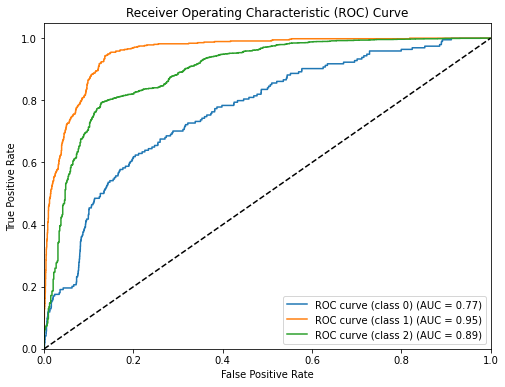

In [37]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Calculate accuracy
en_accuracy = accuracy_score(y_test_enc, ensemble_model.predict(X_test_glv))
print("Ensemble Model Accuracy:", en_accuracy)

# Calculate F1 score
en_f1_score = f1_score(y_test_enc, ensemble_model.predict(X_test_glv), average='weighted')
print("Ensemble Model F1 Score:", en_f1_score)

# Calculate precision
en_precision = precision_score(y_test_enc, ensemble_model.predict(X_test_glv), average='weighted')
print("Ensemble Model Precision:", en_precision)

# Calculate recall
en_recall = recall_score(y_test_enc, ensemble_model.predict(X_test_glv), average='weighted')
print("Ensemble Model Recall:", en_recall)

# Calculate AUC score
from sklearn.metrics import roc_auc_score, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels
y_test_binarized = label_binarize(y_test_enc, classes=range(len(label_encoder.classes_)))

# Calculate ROC AUC score for each class separately
y_score = ensemble_model.predict_proba(X_test_glv)
en_auc_scores = roc_auc_score(y_test_binarized, y_score, average='weighted', multi_class='ovr')
print("Ensemble Model AUC Scores per class:", en_auc_scores)

# Calculate confusion matrix
en_conf_matrix = confusion_matrix(y_test_enc, ensemble_model.predict(X_test_glv))
print("Ensemble Model Confusion Matrix:")
print(en_conf_matrix)

from sklearn.metrics import roc_curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
# Get input from the user
user_input = input("Enter the text you want to classify: ")

# Preprocess the user input
user_input_processed = preprocess(user_input)

# Transform the preprocessed input using the TF-IDF vectorizer
user_input_vectorized = sentence_to_vector(user_input_processed, nlp, glove_vectors).reshape(1, -1)

# Make prediction using the ensemble model
prediction = ensemble_model.predict(user_input_vectorized)

# Print the predicted label
print("Predicted label:", prediction)

Enter the text you want to classify: hello
Predicted label: [2]
